In [153]:
## Scientific Computing with Python
import pandas as pd
import numpy as np

## Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.compat import lzip

## File dirtectory
import os

In this file, we will model how time varying co-variates such as employment status and occupations affect the cognitive scores such as recall index. We consider the following modelling strategy:

- Dependent variables: RwTR20 and RwMSTOT, but they will be transformed into percentages of measurements at age 65 (the retirement age)
- Independent variables: 
    - Time: years after age 65, continuous
    - Employment: including whether employed or not, and specific occupation categories
    - Work condition: wage + hours + physical-effort + eyesight + kneeling-stooping + stress + lifting, categorical
    - Demographic: cohort (categorical), years of education (continuous), number of siblings (categorical)

Part 1 (Main Effect):
1. Baseline model: cognitive score ~ 1 + employment status + time
2. Occupation model: cognitive score ~ 1 + occupation category + time
3. Condition model: cognitive score ~ 1 + occupation category + wage + hours + physical-effort + eyesight + kneeling-stooping + stress + lifting + time
4. Demographics: cognitive score ~ 1 + occupation category + wage + hours + physical-effort + eyesight + kneeling-stooping + stress + lifting + cohort + years of education + number of siblings + time

Part 2 (Random Effect):
1. Condition model + Individual random effect

# 1. Loading and Preparing the Longitudinal Data

In [4]:
hrsByWave = pd.read_csv("joinedWaves10kRows.csv")
hrsByWave.columns

Index(['HHIDPN', 'Wave', 'RwCENREG', 'RwMSTAT', 'RwAGEM_B', 'RwLIVBRO',
       'RwSTATUS', 'RwIMRC', 'RwDLRC', 'RwSER7', 'RwVOCAB', 'RwBWC86',
       'RwBWC20', 'RwTR20', 'RwMSTOT', 'RwLOST', 'RwWANDER', 'RwALONE',
       'RwHALUC', 'RwWORK', 'RwJHOURS', 'RwWGIHR', 'RwJCIND', 'RwJCOCC',
       'RwJPHYS', 'RwJLIFT', 'RwJSTRES', 'RwJSTOOP', 'RwJSIGHT'],
      dtype='object')

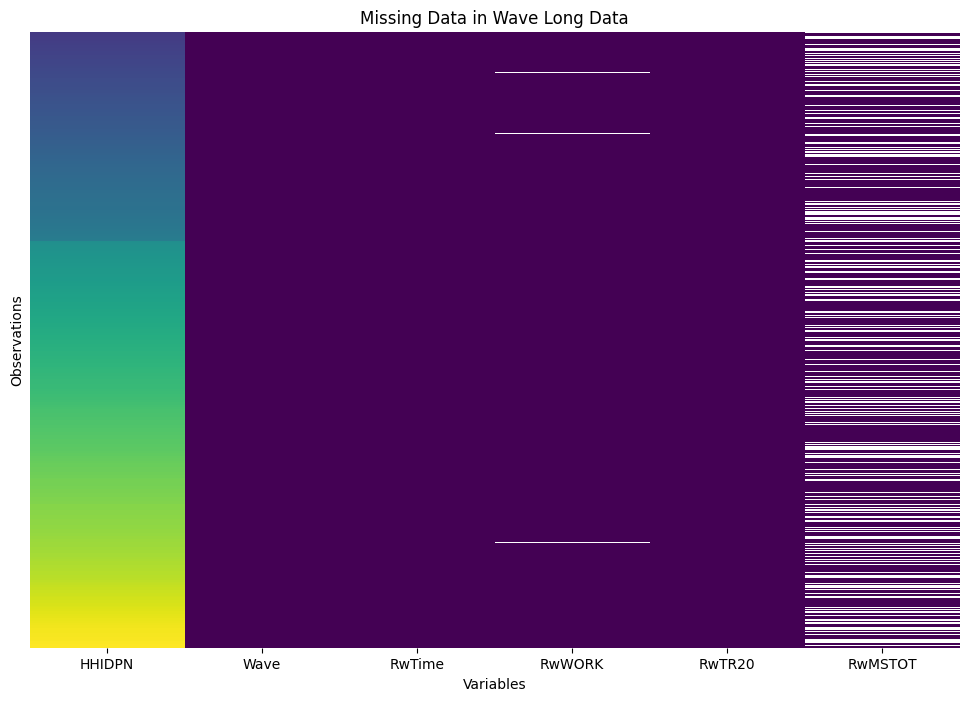

,HHIDPN,Wave,RwTime,RwWORK,RwTR20,RwMSTOT
18,2010,3,-3.000000,0.0,9.0,11.0
19,2010,4,-1.333333,0.0,9.0,NaN
20,2010,5,0.416667,0.0,8.0,6.0
34,3010,3,-4.500000,1.0,20.0,15.0
35,3010,4,-2.750000,1.0,16.0,NaN
36,3010,5,-0.833333,1.0,20.0,NaN
37,3010,6,1.250000,1.0,18.0,13.0
38,3010,7,3.500000,1.0,7.0,11.0
39,3010,8,5.166667,0.0,6.0,14.0
40,3010,9,7.083333,0.0,12.0,14.0


In [66]:
## Transform the data
## Years since 65
hrsByWave["RwTime"] = hrsByWave['RwAGEM_B']/12 - 65 
hrsByWave["RwTime"].describe()

## Remove rows where all of the variables are NaN
hrsBaseLine = hrsByWave[["HHIDPN", "Wave", "RwTime", "RwWORK", 'RwTR20', 'RwMSTOT']]
hrsBaseLine = hrsBaseLine.dropna(subset=["RwTime", "RwWORK", 'RwTR20', 'RwMSTOT'], how = "all")

## Remove rows where all cognitive scores are null
hrsBaseLine = hrsBaseLine.dropna(subset=['RwTR20', 'RwMSTOT'], how = "all")

## plot missingness heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(hrsBaseLine, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Wave Long Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()
hrsBaseLine.head(20)

C:\Users\86139\AppData\Local\Temp\ipykernel_28948\1248249567.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hrsBaseLine = hrsBaseLine.fillna(axis = 1, method = "ffill")


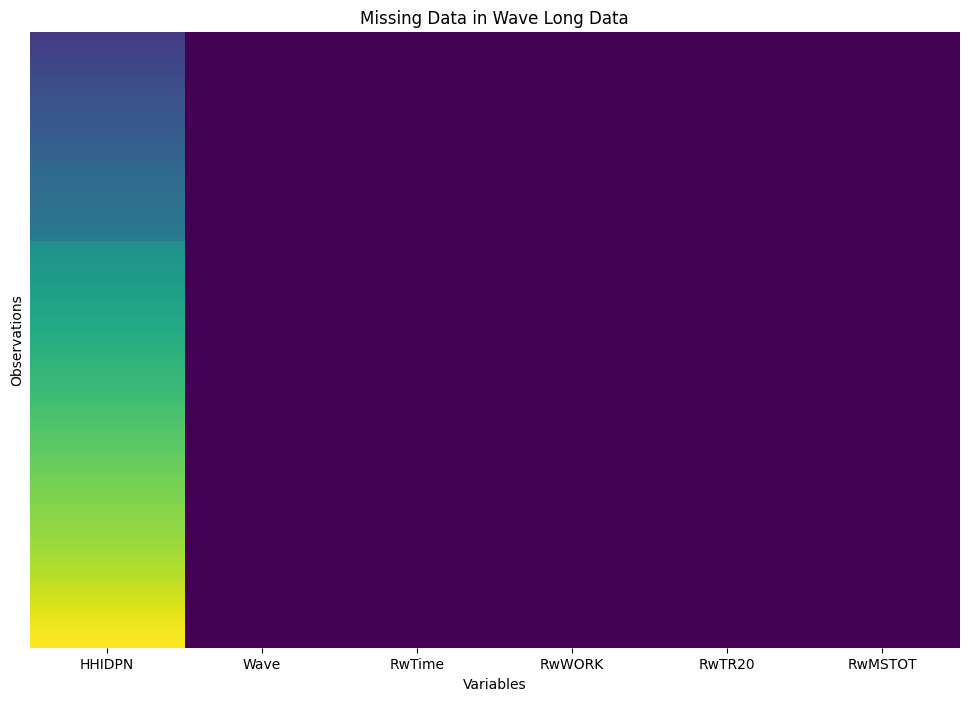

,HHIDPN,Wave,RwTime,RwWORK,RwTR20,RwMSTOT
18,2010.0,3.0,-3.000000,0.0,9.0,11.0
19,2010.0,4.0,-1.333333,0.0,9.0,9.0
20,2010.0,5.0,0.416667,0.0,8.0,6.0
34,3010.0,3.0,-4.500000,1.0,20.0,15.0
35,3010.0,4.0,-2.750000,1.0,16.0,16.0
36,3010.0,5.0,-0.833333,1.0,20.0,20.0
37,3010.0,6.0,1.250000,1.0,18.0,13.0
38,3010.0,7.0,3.500000,1.0,7.0,11.0
39,3010.0,8.0,5.166667,0.0,6.0,14.0
40,3010.0,9.0,7.083333,0.0,12.0,14.0


In [67]:
## Fill the rest of missing values of each column by the last value observed
hrsBaseLine = hrsBaseLine.fillna(axis = 1, method = "ffill")

plt.figure(figsize=(12, 8))
sns.heatmap(hrsBaseLine, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Wave Long Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()

hrsBaseLine.head(20)

In [81]:
def convertToPct(df, timeCol, cogniCols):
    '''
    For each individual, find the time that is the closest to 0, treat it as 1. 
    Compute the percentage of the cognitive scores relative to the reference

    df: the dataframe
    timeCol: column name of time
    cogniCols: a list of cognitive score columns

    Returns: 
    a dataframe with cogni columns transformed
    '''
    df = df.copy()
    for cogniCol in cogniCols:
        # Find baseline (closest to time 0) for each individual
        baseline = df.loc[df.groupby('HHIDPN')[timeCol].apply(lambda x: x.abs().idxmin()), ['HHIDPN', cogniCol]]
        baseline = baseline.rename(columns={cogniCol: f"{cogniCol}_baseline"})
        # Merge baseline back to main df
        df = df.merge(baseline, on='HHIDPN', how='left')
        # Compute percent
        df[f"{cogniCol}_pct"] = df[cogniCol] / df[f"{cogniCol}_baseline"] #* 100
        df.drop(columns=[f"{cogniCol}_baseline"], inplace=True)
    return df

hrsBaseLine = convertToPct(hrsBaseLine, "RwTime", ['RwTR20', 'RwMSTOT'])
hrsBaseLine.head()

,HHIDPN,Wave,RwTime,RwWORK,RwTR20,RwMSTOT,RwTR20_pct,RwMSTOT_pct
0,2010.0,3.0,-3.000000,0.0,9.0,11.0,1.125,1.833333
1,2010.0,4.0,-1.333333,0.0,9.0,9.0,1.125,1.500000
2,2010.0,5.0,0.416667,0.0,8.0,6.0,1.000,1.000000
3,3010.0,3.0,-4.500000,1.0,20.0,15.0,1.000,0.750000
4,3010.0,4.0,-2.750000,1.0,16.0,16.0,0.800,0.800000


# 2. The Baseline Model

In [74]:
## Select variables and construct formulas
yVar1 = 'RwTR20'
yVar2 = 'RwMSTOT'
xVars = ['RwWORK', "RwTime"]

formula1 = f"{yVar1} ~ {' + '.join(xVars)}"
formula2 = f"{yVar2} ~ {' + '.join(xVars)}"

In [70]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(hrsBaseLine, cbar=False, cmap='viridis', yticklabels=False)
# plt.title('Missing Data in Wave Long Data')
# plt.xlabel('Variables')
# plt.ylabel('Observations')
# plt.show()

## Identify HHIDPN and Wave where 'RwTR20_pct' is null
hrsBaseLine[hrsBaseLine['RwTR20_pct'].isnull()]

,HHIDPN,Wave,RwTime,RwWORK,RwTR20,RwMSTOT,RwTR20_pct,RwMSTOT_pct
1996,11936020.0,5.0,-2.583333,0.0,0.0,0.0,NaN,NaN
6910,15332040.0,3.0,3.250000,0.0,0.0,13.0,NaN,1.0
9821,17027010.0,4.0,-7.583333,0.0,0.0,0.0,NaN,NaN
11004,17897020.0,6.0,0.500000,1.0,0.0,6.0,NaN,1.0
11614,18345010.0,4.0,-6.583333,0.0,0.0,0.0,NaN,NaN
12758,19167010.0,6.0,-0.833333,0.0,0.0,0.0,NaN,NaN
16651,21749040.0,3.0,17.750000,0.0,0.0,0.0,NaN,NaN
18522,22858010.0,4.0,-2.833333,0.0,0.0,0.0,NaN,NaN
18523,22858010.0,5.0,-0.500000,0.0,0.0,0.0,NaN,NaN
18662,22938011.0,10.0,1.083333,1.0,0.0,13.0,NaN,1.0


In [82]:
# del m1Recall
# del m2Mental
# import gc
# gc.collect() 

## Drop all rows where percentage of recall index is unavailable
hrsBaseLine.dropna(subset = ["RwTR20_pct"], axis = 0, inplace=True)

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='RwTR20_pct', ylabel='Count'>

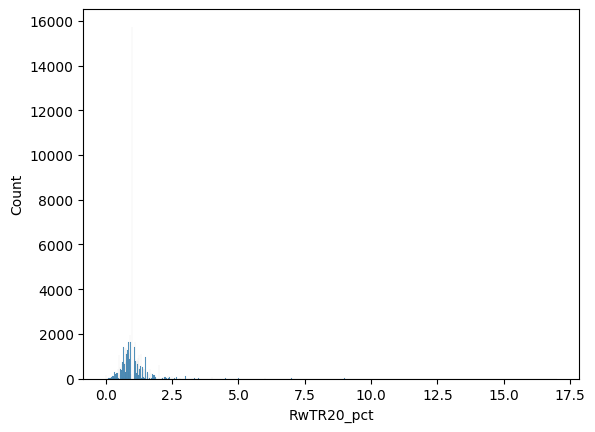

In [83]:
sns.histplot(data = hrsBaseLine, x = "RwTR20_pct")

In [ ]:
m1Recall = smf.mixedlm(formula1, data = hrsBaseLine, groups = hrsBaseLine["HHIDPN"]).fit()
print(m1Recall.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RwTR20      
No. Observations: 64849   Method:             REML        
No. Groups:       8732    Scale:              5.7882      
Min. group size:  1       Log-Likelihood:     -157703.1417
Max. group size:  11      Converged:          Yes         
Mean group size:  7.4                                     
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept  10.212     0.029  347.361  0.000  10.154  10.269
RwWORK      0.097     0.020    4.824  0.000   0.058   0.137
RwTime     -0.148     0.002  -90.017  0.000  -0.151  -0.145
Group Var   5.785     0.047                                



**Observations**:
1. The baseline average recall index percentage relative to age 65 is 
2. RwWork has positive effect in boosting recall capabilities, and the estimate is statistically significant
3. RwTime has negative effect in recall capabilities, and the estimate is statistically significant
4. The residual standard error is ##, and the random effect contributed by different individual is ##, accounting a large amount of variability

In [ ]:
m2Mental = smf.mixedlm(formula2, data = hrsBaseLine, groups = hrsBaseLine["HHIDPN"]).fit()
print(m2Mental.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RwMSTOT     
No. Observations: 64878   Method:             REML        
No. Groups:       8737    Scale:              4.3106      
Min. group size:  1       Log-Likelihood:     -147873.9944
Max. group size:  11      Converged:          Yes         
Mean group size:  7.4                                     
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept  12.159     0.024  497.189  0.000  12.111  12.207
RwWORK      0.018     0.017    1.007  0.314  -0.017   0.052
RwTime     -0.007     0.001   -4.987  0.000  -0.010  -0.004
Group Var   3.924     0.038                                



In [87]:
## Select variables and construct formulas
yVar1 = 'RwTR20_pct'
yVar2 = 'RwMSTOT_pct'
xVars = ['RwWORK', "RwTime"]

formula1 = f"{yVar1} ~ {' + '.join(xVars)}"
formula2 = f"{yVar2} ~ {' + '.join(xVars)}"

In [85]:
m1Recall = smf.mixedlm(formula1, data = hrsBaseLine, groups = hrsBaseLine["HHIDPN"]).fit(method = 'bfgs')
print(m1Recall.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RwTR20_pct 
No. Observations: 64849   Method:             REML       
No. Groups:       8732    Scale:              0.0971     
Min. group size:  1       Log-Likelihood:     -25414.7749
Max. group size:  11      Converged:          Yes        
Mean group size:  7.4                                    
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      1.044    0.004 267.114 0.000  1.036  1.051
RwWORK         0.004    0.003   1.493 0.135 -0.001  0.009
RwTime        -0.015    0.000 -68.812 0.000 -0.015 -0.014
Group Var      0.104    0.006                            



**Observations**:
1. The baseline average recall index percentage relative to age 65 is 1.044, meaning that the average cognitive score across ages is better than that of age 65, which is counter-intuitive
2. RwWork has a weak positive effect in boosting recall capabilities (only 0.4%), and the estimate is not statistically significant
3. RwTime has negative effect in recall capabilities (1.5% decrease per year), and the estimate is statistically significant
4. The residual standard error is 0.0971, and the random effect contributed by different individual is 0.104, accounting a large amount of variability.
5. Compared using the absolute value of recall index as the response, the maximum log likelihood dropped from -147873.9944 to -25414.7749, which might suggest a poorer fit of the model.
6. The std.err of each parameter estimates are close to 0 (near 0 for RwTime), which may cause numerical convergence issue.

In [86]:
m2Mental = smf.mixedlm(formula2, data = hrsBaseLine, groups = hrsBaseLine["HHIDPN"]).fit(method = 'bfgs')
print(m2Mental.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RwMSTOT_pct
No. Observations: 64849   Method:             REML       
No. Groups:       8732    Scale:              0.0675     
Min. group size:  1       Log-Likelihood:     -15434.4964
Max. group size:  11      Converged:          Yes        
Mean group size:  7.4                                    
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      1.070    0.004 269.962 0.000  1.062  1.078
RwWORK        -0.004    0.002  -1.682 0.093 -0.008  0.001
RwTime        -0.002    0.000  -8.780 0.000 -0.002 -0.001
Group Var      0.116    0.008                            



**Observations**:
1. The baseline average mental state index percentage relative to age 65 is 107%, meaning that the average cognitive score across ages is better than that of age 65, which is counter-intuitive
2. RwWork has a weak positive effect in boosting mental state (only 0.4%), and the estimate is not statistically significant
3. RwTime has weak effect in recall capabilities (0.2% decrease per year), and the estimate is statistically significant
4. The residual standard error is 0.0971, and the random effect contributed by different individual is 0.104, accounting a large amount of variability.
5. Compared using the absolute value of recall index as the response, the maximum log likelihood dropped from -147873.9944 to -15434.4964, which might suggest a poorer fit of the model.
6. The std.err of each parameter estimates are close to 0 (near 0 for RwTime), which may cause numerical convergence issue.
7. The data contains 64849 records of 8732 individuals, the length of individual range from 1 to 11, with mean length of 7.4

# 3. The Occupation Model

We will left join a subset of the table `hrsBaseLine` containing `RwJCOCC` with table `hrsBywave` on `HHIDPN` and `Wave`. We will treat occupations of individuals not working for pay as well NAs as the baseline occupation: "retired."

In [92]:
occupation_dict = {
    1: "Managerial specialty ope",
    2: "Prof specialty opr/tech",
    3: "Sales",
    4: "Clerical/admin supp",
    5: "Svc:prv hhld/clean/bldg",
    6: "Svc:protection",
    7: "Svc:food prep",
    8: "Health svc",
    9: "Personal svc",
    10: "Farming/forestry/fishing",
    11: "Mechanics/repair",
    12: "Constr trade/extractors",
    13: "Precision production",
    14: "Operators: machine",
    15: "Operators: transport, et",
    16: "Operators: handlers, etc",
    17: "Member of Armed Forces"
}

hrsByWave["RwJCOCC"] = hrsByWave["RwJCOCC"].map(occupation_dict)
hrsByWave["RwJCOCC"].fillna(value = "Retired", inplace=True)
hrsByWave.RwJCOCC.unique()

C:\Users\86139\AppData\Local\Temp\ipykernel_28948\1741790808.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hrsByWave["RwJCOCC"].fillna(value = "Retired", inplace=True)


array(['Svc:food prep', 'Retired', 'Personal svc', 'Precision production',
       'Operators: transport, et', 'Clerical/admin supp', 'Sales',
       'Managerial specialty ope', 'Prof specialty opr/tech',
       'Operators: machine', 'Svc:protection', 'Health svc',
       'Constr trade/extractors', 'Operators: handlers, etc',
       'Svc:prv hhld/clean/bldg', 'Mechanics/repair',
       'Farming/forestry/fishing', 'Member of Armed Forces'], dtype=object)

In [95]:
hrsOcc = pd.merge(hrsBaseLine, hrsByWave[["HHIDPN", "Wave", "RwJCOCC"]], how = "left",
                  on=["HHIDPN", "Wave"])
print(hrsOcc.head())
print(hrsOcc[hrsOcc.RwWORK == 0].head())

   HHIDPN  Wave    RwTime  RwWORK  RwTR20  RwMSTOT  RwTR20_pct  RwMSTOT_pct  \
0  2010.0   3.0 -3.000000     0.0     9.0     11.0       1.125     1.833333   
1  2010.0   4.0 -1.333333     0.0     9.0      9.0       1.125     1.500000   
2  2010.0   5.0  0.416667     0.0     8.0      6.0       1.000     1.000000   
3  3010.0   3.0 -4.500000     1.0    20.0     15.0       1.000     0.750000   
4  3010.0   4.0 -2.750000     1.0    16.0     16.0       0.800     0.800000   

                    RwJCOCC  
0                   Retired  
1                   Retired  
2                   Retired  
3  Operators: transport, et  
4       Clerical/admin supp  
   HHIDPN  Wave    RwTime  RwWORK  RwTR20  RwMSTOT  RwTR20_pct  RwMSTOT_pct  \
0  2010.0   3.0 -3.000000     0.0     9.0     11.0       1.125     1.833333   
1  2010.0   4.0 -1.333333     0.0     9.0      9.0       1.125     1.500000   
2  2010.0   5.0  0.416667     0.0     8.0      6.0       1.000     1.000000   
8  3010.0   8.0  5.166667    

In [114]:
## Select variables and construct formulas
yVar1 = 'RwTR20_pct'
yVar2 = 'RwMSTOT_pct'
xVars = ['RwJCOCC', "RwTime"]

formula1 = f"{yVar1} ~ C(RwJCOCC, Treatment(reference='Retired')) + RwTime"
formula2 = f"{yVar2} ~ C(RwJCOCC, Treatment(reference='Retired')) + RwTime"

In [115]:
formula1

"RwTR20_pct ~ C(RwJCOCC, Treatment(reference='Retired')) + RwTime"

In [116]:
m1Recall = smf.mixedlm(formula1, data = hrsOcc, groups = hrsOcc["HHIDPN"]).fit(method = "bfgs")
print(m1Recall.summary())

                                      Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    RwTR20_pct 
No. Observations:                    64849                      Method:                                REML       
No. Groups:                          8732                       Scale:                                 0.0971     
Min. group size:                     1                          Log-Likelihood:                        -25439.0418
Max. group size:                     11                         Converged:                             Yes        
Mean group size:                     7.4                                                                          
------------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----

In [141]:
# m1RecallSmry = m1Recall.summary()
m1RecallParam = pd.concat([m1Recall.fe_params, m1Recall.pvalues], axis = 1)
m1RecallParam = m1RecallParam.loc[m1RecallParam[1] < 0.05, :]
m1RecallParam.sort_values(0)

,0,1
"C(RwJCOCC, Treatment(reference='Retired'))[T.Prof specialty opr/tech]",-0.019168,0.015754
RwTime,-0.014790,0.000000
"C(RwJCOCC, Treatment(reference='Retired'))[T.Svc:food prep]",0.035612,0.026141
"C(RwJCOCC, Treatment(reference='Retired'))[T.Operators: handlers, etc]",0.047366,0.009170
"C(RwJCOCC, Treatment(reference='Retired'))[T.Farming/forestry/fishing]",0.058578,0.001644
"C(RwJCOCC, Treatment(reference='Retired'))[T.Svc:prv hhld/clean/bldg]",0.073127,0.001424
Intercept,1.044724,0.000000
Group Var,NaN,0.000000


**Observation**:
1. Occupations that associate with recall index decline:

| Occupations | Effects | P-values |
|-------------|----------|----------|
|professional in operation and technology | -1.9168% | 0.015754|

2. Occupations that associate with recall index boost: 


| Occupations | Effects | P-values |
|-------------|----------|----------|
|Operators and handlers | 4.7366% | 0.009170|
|T.Farming/forestry/fishing| 5.8578% |	0.001644 |
|T.Svc:prv hhld/clean/bldg|	7.3127%|	0.001424|

In [156]:
## Model Diagnostics
name = ["Jarque-Bera test", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(m1Recall.resid)
lzip(name, test)

[('Jarque-Bera test', 9733861.364115605),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.4931833659092726),
 ('Kurtosis', 62.94573719507785)]

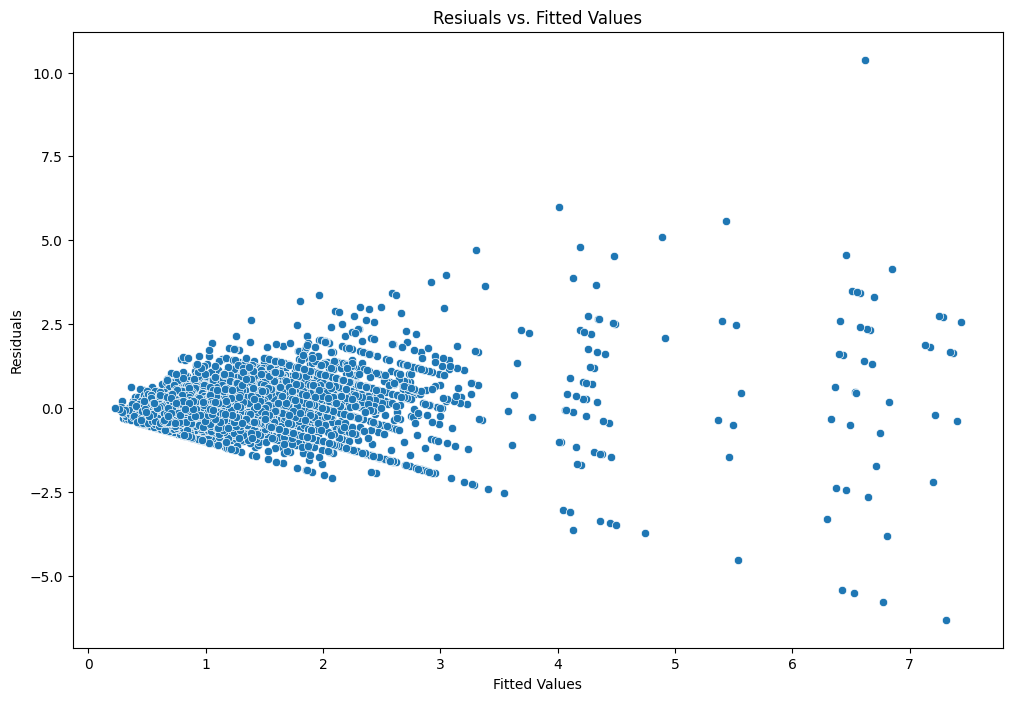

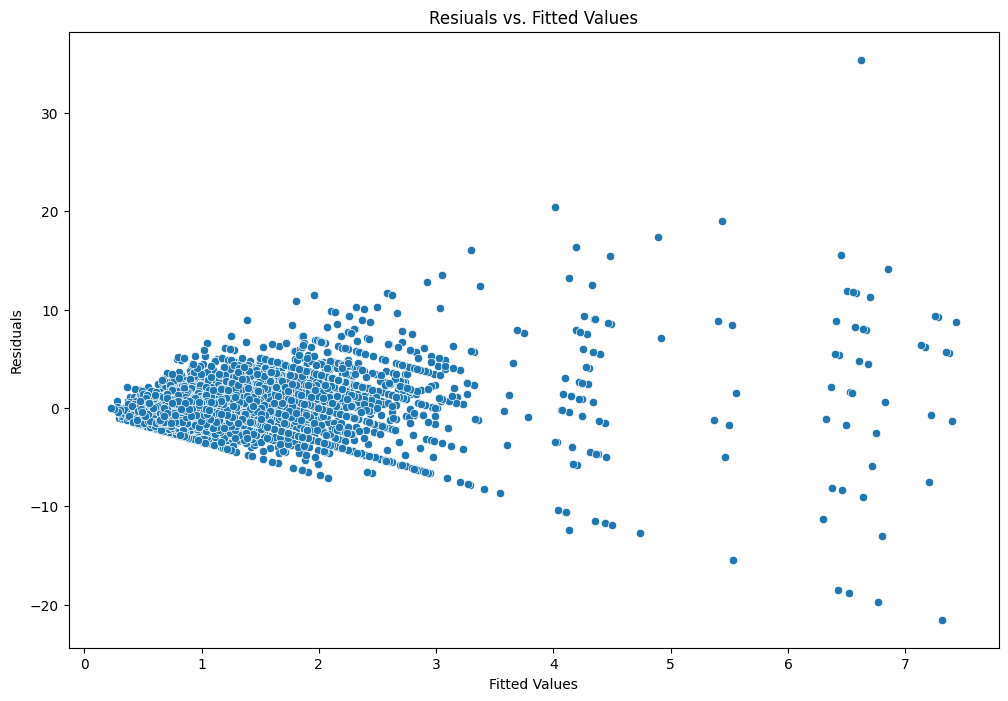

In [162]:
fittedVal = m1Recall.fittedvalues
estResid  = m1Recall.resid
sigmaResid = estResid.std()
stdResid = estResid / sigmaResid

plt.figure(figsize=(12, 8))
sns.scatterplot(x = fittedVal, y=estResid)
plt.title("Resiuals vs. Fitted Values")
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x = fittedVal, y=stdResid)
plt.title("Resiuals vs. Fitted Values")
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Unequal variances

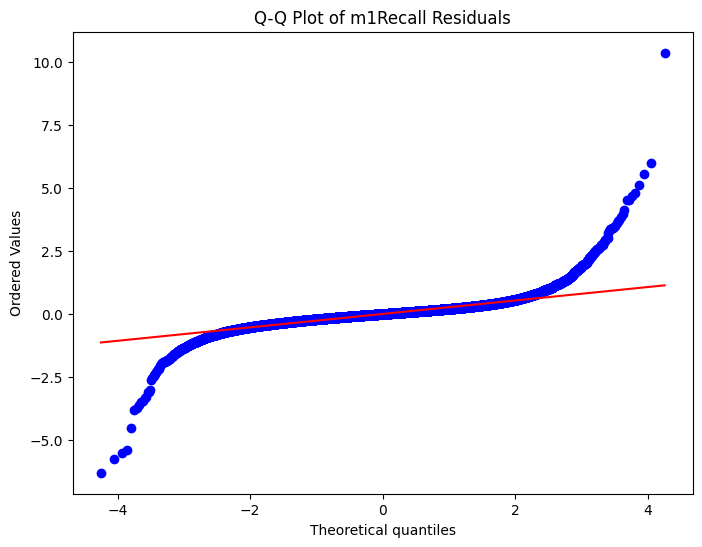

In [161]:
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(m1Recall.resid, dist="norm", plot=plt)
plt.title("Q-Q Plot of m1Recall Residuals")
plt.show()

Though residuals are symmetrically distributed, the kurtosis is much higher than the normal distribution. Normal distribution assumptions are violated.


# 4. The Work Condition Model

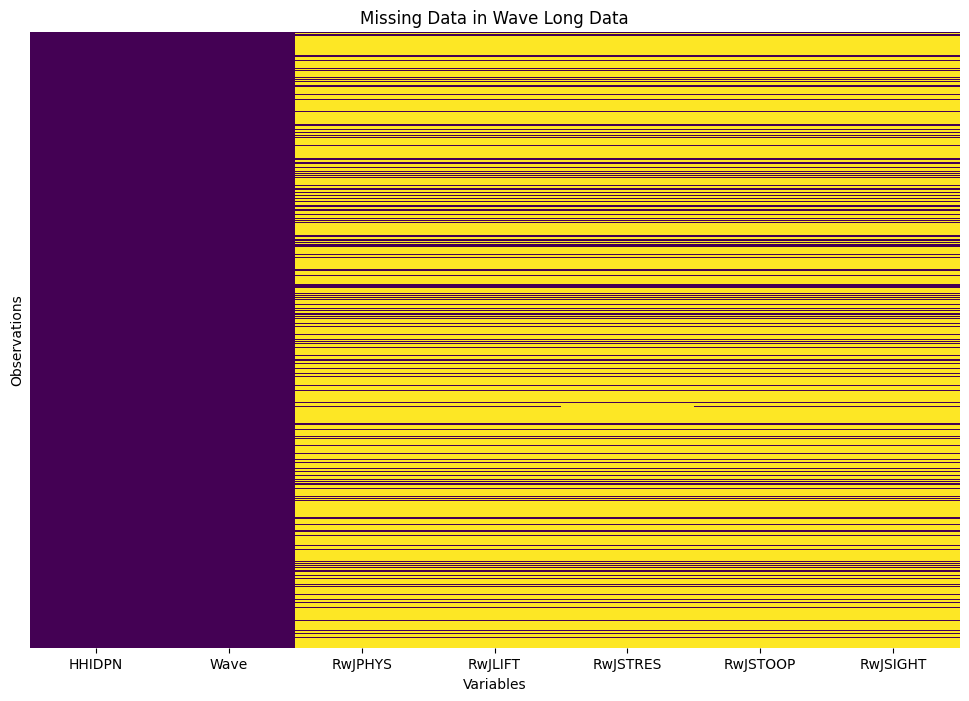

In [310]:
# print((hrsOcc["RwJCOCC"] == "Retired").mean())
# ## Five percent overestimation of retired elderlies composition
# print(1-hrsOcc["RwWORK"].mean())


## Get work conditions and inspect missingness
hrsWorkCond = hrsByWave[["HHIDPN", "Wave", "RwJPHYS", "RwJLIFT", "RwJSTRES", "RwJSTOOP", "RwJSIGHT"]]

plt.figure(figsize=(12, 8))
sns.heatmap(hrsWorkCond.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Wave Long Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()

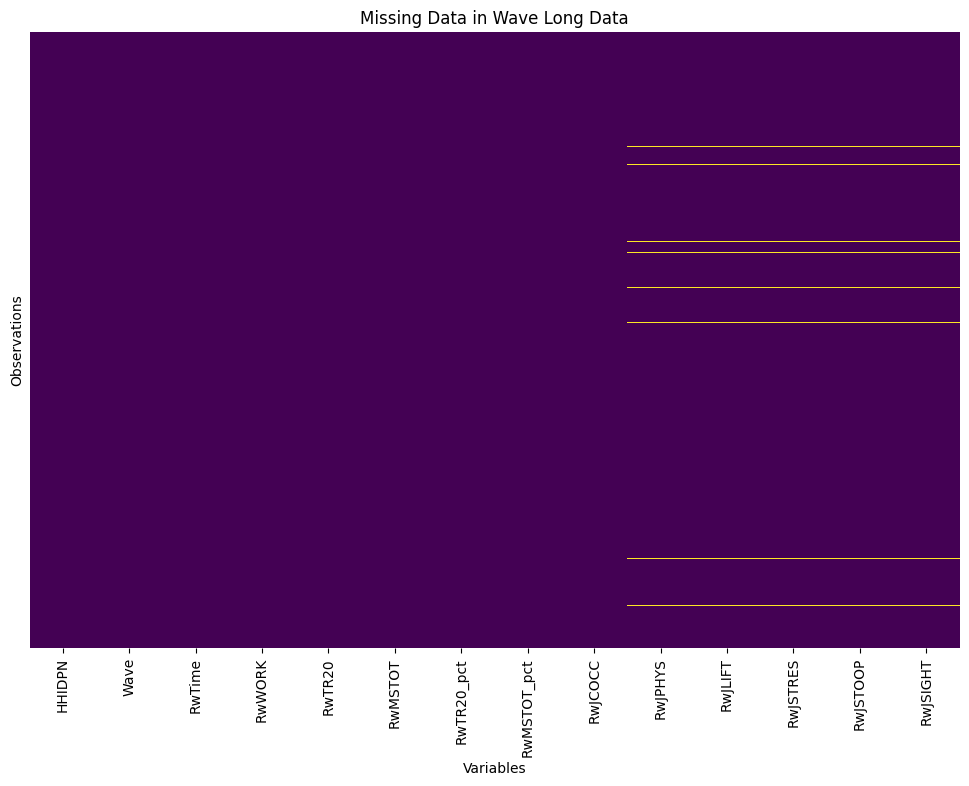

In [311]:
## Left join with hrs occupation
hrsWorkCond = pd.merge(hrsOcc, hrsWorkCond, on = ["HHIDPN", "Wave"], how = "left")

## For all retired particiants, impute work conditions by value 0
retiredIdx = (hrsWorkCond["RwWORK"] == 0)
hrsWorkCond.loc[retiredIdx, ["RwJPHYS", "RwJLIFT", "RwJSTRES", "RwJSTOOP", "RwJSIGHT"]] = 5 ## 5 codes "does not apply"
hrsWorkCond[["RwJPHYS", "RwJLIFT", "RwJSTRES", "RwJSTOOP", "RwJSIGHT"]] = hrsWorkCond[["RwJPHYS", "RwJLIFT", "RwJSTRES", "RwJSTOOP", "RwJSIGHT"]].astype("category")

## Inspect missingness again
plt.figure(figsize=(12, 8))
sns.heatmap(hrsWorkCond.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Wave Long Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()

In [312]:
## Pull out individuals with null work conditions, see if all or some of their surveys missed work conditions
workCondVars = ["RwJPHYS", "RwJLIFT", "RwJSTRES", "RwJSTOOP", "RwJSIGHT"]
workCondMissIdx = hrsWorkCond[workCondVars].isnull().any(axis = 1)
workCondMissID = hrsWorkCond.loc[workCondMissIdx, "HHIDPN"].unique()
workCondMissFrame = hrsWorkCond.loc[hrsWorkCond["HHIDPN"].isin(workCondMissID), ["HHIDPN", "Wave"] + workCondVars]
print(workCondMissFrame.head(20))

         HHIDPN  Wave RwJPHYS RwJLIFT RwJSTRES RwJSTOOP RwJSIGHT
73   10013040.0   3.0     4.0     4.0      1.0      4.0      1.0
74   10013040.0   4.0     4.0     4.0      1.0      4.0      1.0
75   10013040.0   5.0     4.0     4.0      1.0      4.0      1.0
76   10013040.0   6.0     4.0     4.0      1.0      4.0      1.0
77   10013040.0   7.0     4.0     4.0      1.0      4.0      1.0
78   10013040.0   8.0     5.0     5.0      5.0      5.0      5.0
79   10013040.0   9.0     NaN     NaN      NaN      NaN      NaN
80   10013040.0  10.0     5.0     5.0      5.0      5.0      5.0
81   10013040.0  11.0     5.0     5.0      5.0      5.0      5.0
82   10013040.0  12.0     5.0     5.0      5.0      5.0      5.0
83   10013040.0  13.0     5.0     5.0      5.0      5.0      5.0
272  10281010.0   3.0     5.0     5.0      5.0      5.0      5.0
273  10281010.0   4.0     NaN     NaN      3.0      NaN      NaN
274  10281010.0   5.0     NaN     NaN      2.0      NaN      NaN
275  10281010.0   6.0    

In [215]:
## Check if the first work condition record of each ID is always non.null
workCondMissFrame.groupby("HHIDPN").first().info()
## not necessary. There are 429 distinct individuals in total, and on average 15-16 first observations have missing values

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 10013040.0 to 61249010.0
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Wave      429 non-null    float64 
 1   RwJPHYS   413 non-null    category
 2   RwJLIFT   414 non-null    category
 3   RwJSTRES  418 non-null    category
 4   RwJSTOOP  414 non-null    category
 5   RwJSIGHT  414 non-null    category
dtypes: category(5), float64(1)
memory usage: 9.8 KB


In [314]:
# hrsWorkCond = hrsWorkCond.groupby("HHIDPN").apply(lambda df: df.fillna(method="ffill"))
# hrsWorkCond = hrsWorkCond.reset_index()
# hrsWorkCond = hrsWorkCond.groupby("HHIDPN").apply(lambda df: df.fillna(method = "ffill", axis = 1))

# ## If not prior work cindition, propogage latter records backward
# hrsWorkCond = hrsWorkCond.groupby("HHIDPN").apply(lambda df: df.fillna(method = "backfill", axis = 1))

hrsWorkCond = hrsWorkCond.fillna(method="ffill", axis = 0)
hrsWorkCond = hrsWorkCond.fillna(method="bfill", axis = 0)
hrsWorkCond = hrsWorkCond.fillna(5, axis = 0)
# ## Inspect missingness
hrsWorkCond[workCondVars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64849 entries, 0 to 64848
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   RwJPHYS   64849 non-null  category
 1   RwJLIFT   64849 non-null  category
 2   RwJSTRES  64849 non-null  category
 3   RwJSTOOP  64849 non-null  category
 4   RwJSIGHT  64849 non-null  category
dtypes: category(5)
memory usage: 317.8 KB


C:\Users\86139\AppData\Local\Temp\ipykernel_28948\2461634680.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hrsWorkCond = hrsWorkCond.fillna(method="ffill", axis = 0)
C:\Users\86139\AppData\Local\Temp\ipykernel_28948\2461634680.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hrsWorkCond = hrsWorkCond.fillna(method="bfill", axis = 0)


In [338]:
workCondMapper = {
    1:"Always",
    2:"Often",
    3:"Sometimes",
    4:"Seldom",
    5:"NotApplicable"
}

hrsWorkCond[workCondVars] = hrsWorkCond[workCondVars].apply(lambda x: x.map(workCondMapper), axis = 1)

In [315]:
## Select variables and construct formulas
yVar1 = 'RwTR20_pct'
yVar2 = 'RwMSTOT_pct'
xVars = ['RwJCOCC', "RwTime"] + workCondVars
# C(RwJCOCC, Treatment(reference='Retired'))
formula1 = f"{yVar1} ~ RwTime + " + ' + '.join(workCondVars)
formula2 = f"{yVar2} ~ RwTime + " + ' + '.join(workCondVars)

In [323]:
hrsWorkCond.reset_index(inplace = True)
hrsWorkCond.drop("index", axis = 1, inplace = True)

In [324]:
hrsWorkCond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64849 entries, 0 to 64848
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   level_0      64849 non-null  int64   
 1   HHIDPN       64849 non-null  float64 
 2   Wave         64849 non-null  float64 
 3   RwTime       64849 non-null  float64 
 4   RwWORK       64849 non-null  float64 
 5   RwTR20       64849 non-null  float64 
 6   RwMSTOT      64849 non-null  float64 
 7   RwTR20_pct   64849 non-null  float64 
 8   RwMSTOT_pct  64849 non-null  float64 
 9   RwJCOCC      64849 non-null  object  
 10  RwJPHYS      64849 non-null  category
 11  RwJLIFT      64849 non-null  category
 12  RwJSTRES     64849 non-null  category
 13  RwJSTOOP     64849 non-null  category
 14  RwJSIGHT     64849 non-null  category
dtypes: category(5), float64(8), int64(1), object(1)
memory usage: 5.3+ MB


In [325]:
hrsWorkCond["RwTR20_pct"] = hrsWorkCond["RwTR20_pct"].astype(float)

In [339]:
m1Recall = smf.mixedlm(formula1, data = hrsWorkCond, groups = hrsWorkCond["HHIDPN"]).fit(method = "bfgs")
print(m1Recall.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     RwTR20_pct 
No. Observations:     64849       Method:                 REML       
No. Groups:           8732        Scale:                  0.0971     
Min. group size:      1           Log-Likelihood:         -25459.9992
Max. group size:      11          Converged:              Yes        
Mean group size:      7.4                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  1.075    0.012  88.781 0.000  1.051  1.098
RwJPHYS[T.Often]          -0.011    0.009  -1.161 0.245 -0.028  0.007
RwJPHYS[T.Sometimes]      -0.025    0.009  -2.852 0.004 -0.042 -0.008
RwJPHYS[T.Seldom]         -0.036    0.009  -3.805 0.000 -0.054 -0.017
RwJPHYS[T.NotApplicable]   0.004    

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0')])

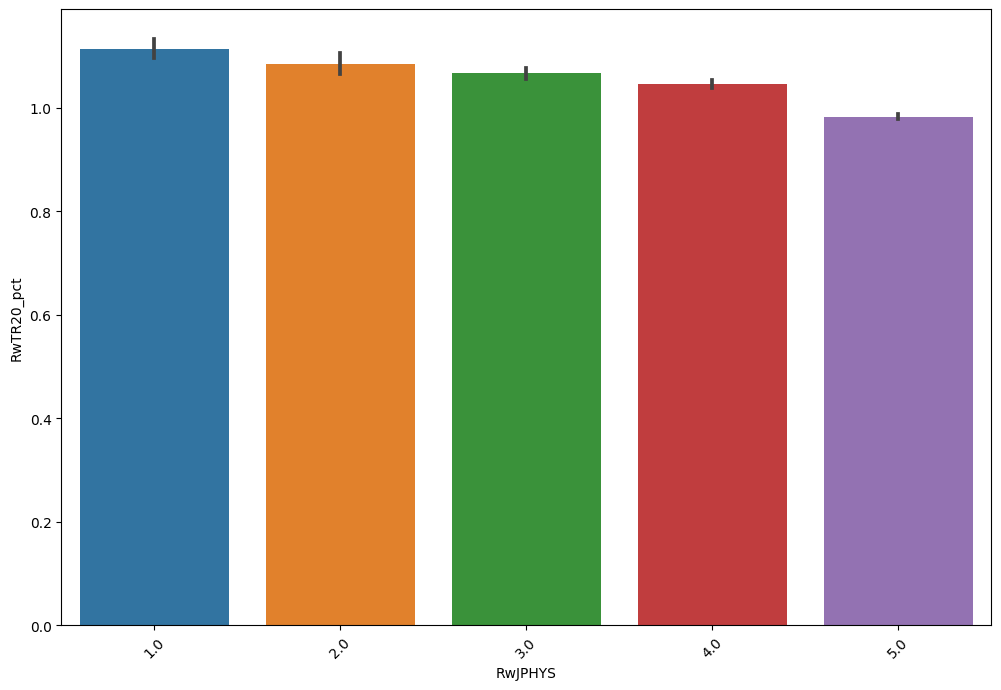

In [327]:
plt.figure(figsize = (12, 8))
sns.barplot(data = hrsWorkCond, 
            x = workCondVars[0], y = "RwTR20_pct")
plt.xticks(rotation=45)

In [ ]:
m1ParamTbl = m1Recall.summary().tables[1]
m1ParamTbl
# m1ParamTbl["P>|z|"].dtype

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.075,0.012,88.781,0.000,1.051,1.098
RwJPHYS[T.2.0],-0.011,0.009,-1.161,0.245,-0.028,0.007
RwJPHYS[T.3.0],-0.025,0.009,-2.852,0.004,-0.042,-0.008
RwJPHYS[T.4.0],-0.036,0.009,-3.805,0.000,-0.054,-0.017
RwJPHYS[T.5.0],0.004,0.050,0.089,0.929,-0.094,0.103
RwJLIFT[T.2.0],-0.031,0.015,-2.117,0.034,-0.060,-0.002
RwJLIFT[T.3.0],-0.027,0.012,-2.206,0.027,-0.051,-0.003
RwJLIFT[T.4.0],-0.015,0.013,-1.174,0.240,-0.040,0.010
RwJLIFT[T.5.0],0.012,0.031,0.396,0.692,-0.048,0.073
RwJSTRES[T.2.0],0.009,0.007,1.286,0.198,-0.005,0.024


In [ ]:
m2Mental = smf.mixedlm(formula2, data = hrsWorkCond, groups = hrsWorkCond["HHIDPN"]).fit(method = "bfgs")
print(m2Mental.summary())

                                      Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    RwMSTOT_pct
No. Observations:                    64849                      Method:                                REML       
No. Groups:                          8732                       Scale:                                 0.0675     
Min. group size:                     1                          Log-Likelihood:                        -15455.9004
Max. group size:                     11                         Converged:                             Yes        
Mean group size:                     7.4                                                                          
------------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----

In [284]:
m2Mental.summary().tables[1]["P>|z|"]

Intercept                                                                 0.000
C(RwJCOCC, Treatment(reference='Retired'))[T.Clerical/admin supp]         0.002
C(RwJCOCC, Treatment(reference='Retired'))[T.Constr trade/extractors]     0.638
C(RwJCOCC, Treatment(reference='Retired'))[T.Farming/forestry/fishing]    0.070
C(RwJCOCC, Treatment(reference='Retired'))[T.Health svc]                  0.673
C(RwJCOCC, Treatment(reference='Retired'))[T.Managerial specialty ope]    0.002
C(RwJCOCC, Treatment(reference='Retired'))[T.Mechanics/repair]            0.232
C(RwJCOCC, Treatment(reference='Retired'))[T.Member of Armed Forces]      0.349
C(RwJCOCC, Treatment(reference='Retired'))[T.Operators: handlers, etc]    0.270
C(RwJCOCC, Treatment(reference='Retired'))[T.Operators: machine]          0.107
C(RwJCOCC, Treatment(reference='Retired'))[T.Operators: transport, et]    0.000
C(RwJCOCC, Treatment(reference='Retired'))[T.Personal svc]                0.085
C(RwJCOCC, Treatment(reference='Retired'

In [340]:
hrsWorkCond.to_csv("hrsWorkCond.csv")


* Use random for feature importance
* X Subjective combination of the 